In [1]:
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import copy
        
# Helper function to draw registrations (reccomended)
def draw_registrations(source, target, transformation = None, recolor = False):
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        if(recolor):
            source_temp.paint_uniform_color([1, 0.706, 0])
            target_temp.paint_uniform_color([0, 0.651, 0.929])
        if(transformation is not None):
            source_temp.transform(transformation)
        o3d.visualization.draw_geometries([source_temp, target_temp])

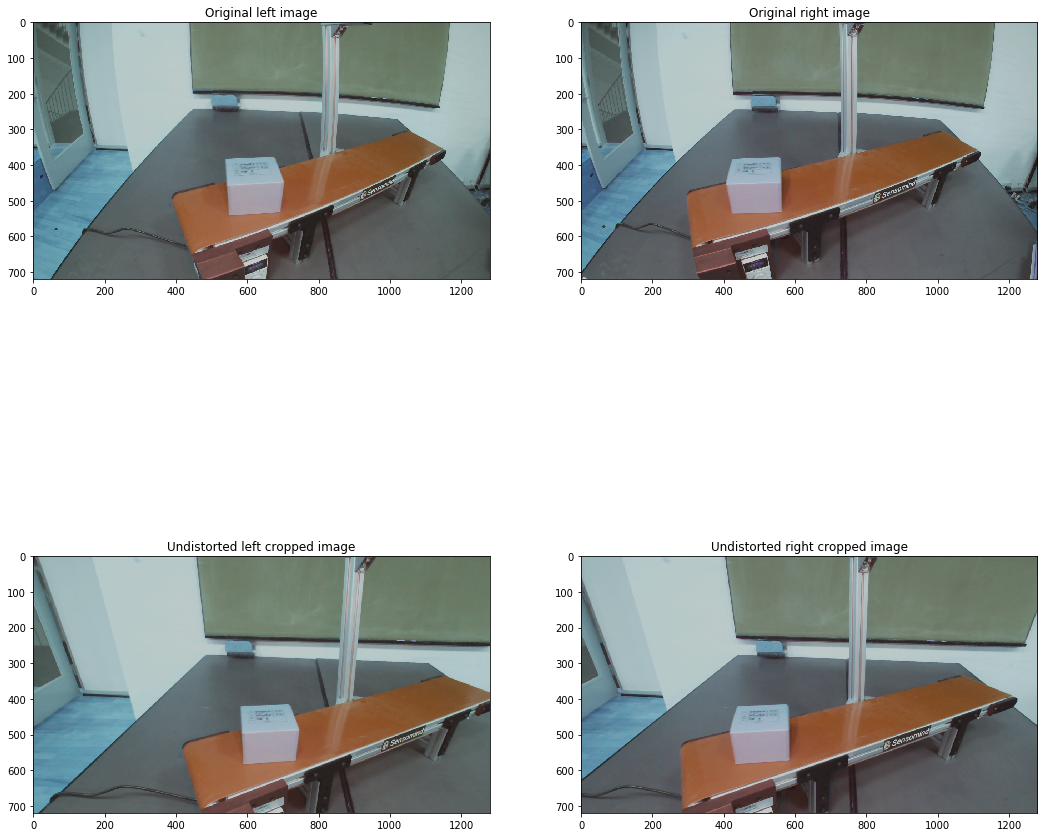

In [2]:
#Aquire source images

imgL = cv2.imread('left/1585434287_538281918_Left.png')  #queryimage # left image
imgR = cv2.imread('right/1585434287_538281918_Right.png') #trainimage # right image


#undistort
data1 = np.load('calib_stereo.npz')
data2 = np.load('rectified_stereo.npz')

map1x, map1y = cv2.initUndistortRectifyMap(data1['cameraMatrix1'], data1['distCoeffs1'], data2['R1'], data2['P1'],(1280, 720), cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(data1['cameraMatrix2'], data1['distCoeffs2'], data2['R2'], data2['P2'],(1280, 720), cv2.CV_32FC1)

imgL_rect = cv2.remap(imgL, map1x, map1y, cv2.INTER_LINEAR);
imgR_rect = cv2.remap(imgR, map2x, map2y, cv2.INTER_LINEAR);


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax[0][0].imshow(imgL)
ax[0][0].set_title('Original left image')
ax[0][1].imshow(imgR)
ax[0][1].set_title('Original right image')
ax[1][0].imshow(imgL_rect)
ax[1][0].set_title('Undistorted left cropped image')
ax[1][1].imshow(imgR_rect)
ax[1][1].set_title('Undistorted right cropped image')

smallL = cv2.resize(imgL_rect, (0,0), fx=0.5, fy=0.5) 
smallR = cv2.resize(imgR_rect, (0,0), fx=0.5, fy=0.5) 

cv2.imwrite( "sc_left_calibrated.png", smallL);
cv2.imwrite( "sc_right_calibrated.png", smallR);

In [4]:
# Initialize disparaty coefs

stereo = cv2.StereoSGBM_create(minDisparity = 0,
        numDisparities = 96,
        blockSize = 9,
        P1 = 477,
        P2 = 2048,
        disp12MaxDiff = 29,
        preFilterCap = 1, 
        uniquenessRatio = 0,
        speckleWindowSize = 0,
        speckleRange = 0
    )

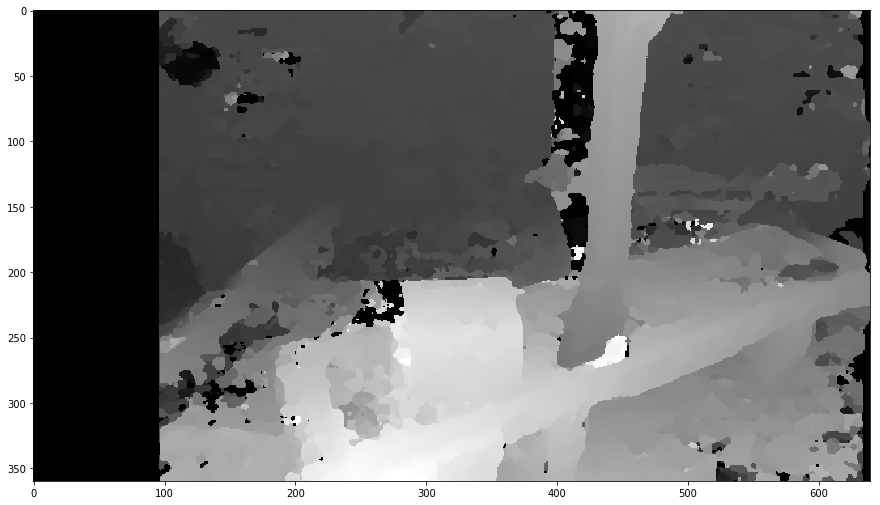

In [6]:
img1_sc= smallL
img2_sc= smallR


disp_sc = stereo.compute(img1_sc, img2_sc).astype(np.float32) / 16.0

plt.figure(figsize = (15,15))
plt.imshow(disp_sc, 'gray')
plt.show()

Q = data2['Q']
depthMapImg_sc = cv2.reprojectImageTo3D(disp_sc, Q)
cv2.imwrite( "sc_depth.png", depthMapImg_sc);

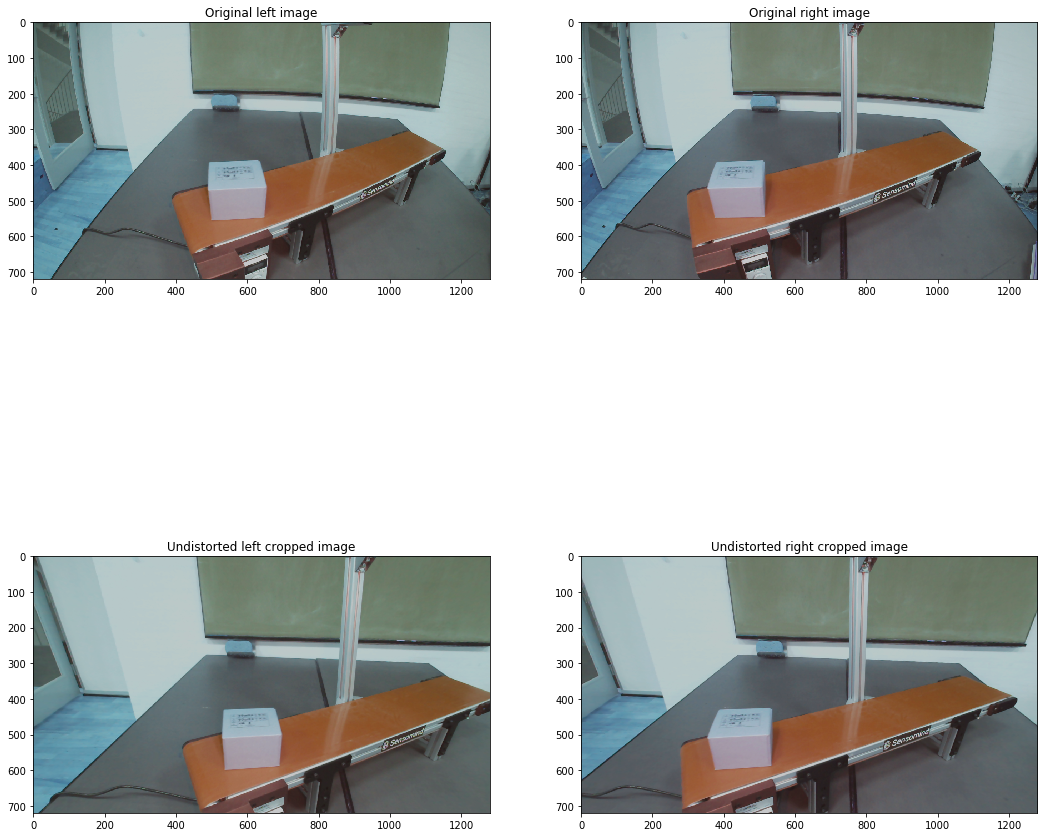

In [7]:
#Aquire target images

imgL = cv2.imread('left/1585434287_770591974_Left.png')  #queryimage # left image
imgR = cv2.imread('right/1585434287_770591974_Right.png') #trainimage # right image


#undistort
data1 = np.load('calib_stereo.npz')
data2 = np.load('rectified_stereo.npz')

map1x, map1y = cv2.initUndistortRectifyMap(data1['cameraMatrix1'], data1['distCoeffs1'], data2['R1'], data2['P1'],(1280, 720), cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(data1['cameraMatrix2'], data1['distCoeffs2'], data2['R2'], data2['P2'],(1280, 720), cv2.CV_32FC1)

imgL_rect = cv2.remap(imgL, map1x, map1y, cv2.INTER_LINEAR);
imgR_rect = cv2.remap(imgR, map2x, map2y, cv2.INTER_LINEAR);


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax[0][0].imshow(imgL)
ax[0][0].set_title('Original left image')
ax[0][1].imshow(imgR)
ax[0][1].set_title('Original right image')
ax[1][0].imshow(imgL_rect)
ax[1][0].set_title('Undistorted left cropped image')
ax[1][1].imshow(imgR_rect)
ax[1][1].set_title('Undistorted right cropped image')

smallL = cv2.resize(imgL_rect, (0,0), fx=0.5, fy=0.5) 
smallR = cv2.resize(imgR_rect, (0,0), fx=0.5, fy=0.5) 

cv2.imwrite( "tg_left_calibrated.png", smallL);
cv2.imwrite( "tg_right_calibrated.png", smallR);


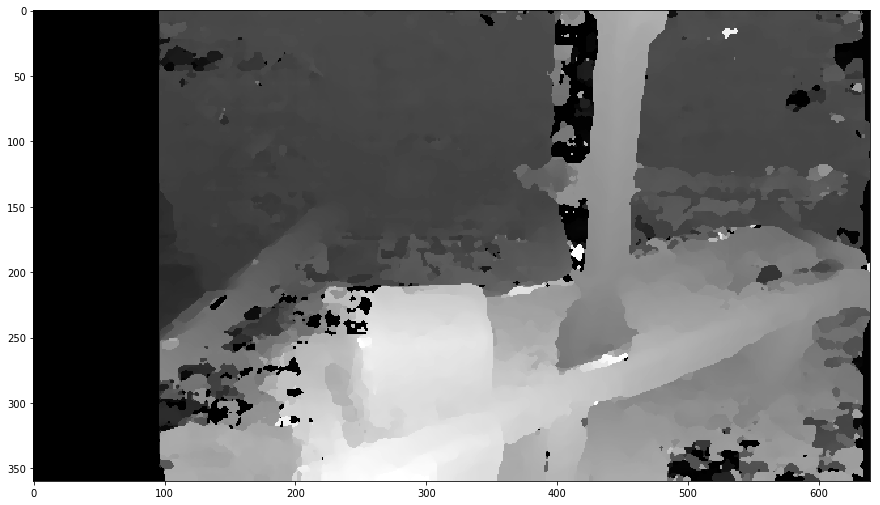

In [9]:
img1_tg= smallL
img2_tg= smallR

disp_tg = stereo.compute(img1_tg, img2_tg).astype(np.float32) / 16.0

plt.figure(figsize = (15,15))
plt.imshow(disp_tg, 'gray')
plt.show()

depthMapImg_tg = cv2.reprojectImageTo3D(disp_tg, Q)
cv2.imwrite( "tg_depth.png", depthMapImg_tg);

In [2]:
# Read in images. We have images 000000 - 0000400
color_sc = o3d.io.read_image("sc_left_calibrated.png")
color_tg = o3d.io.read_image("tg_left_calibrated.png")

depth_sc = o3d.io.read_image("sc_depth.png")
depth_tg = o3d.io.read_image("tg_depth.png")


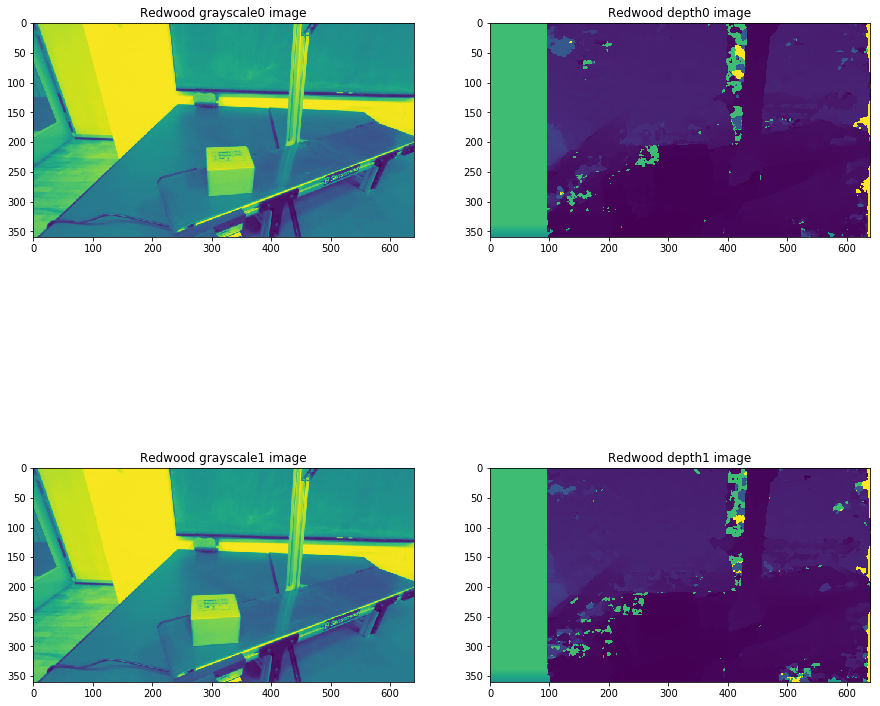

In [3]:
rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_sc, 
    depth_sc, 
    convert_rgb_to_intensity = True)

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_tg, 
    depth_tg, 
    convert_rgb_to_intensity = True)

#show images
fig= plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Redwood grayscale0 image')
plt.imshow(rgbd_image0.color)

plt.subplot(222)
plt.title('Redwood depth0 image')
plt.imshow(rgbd_image0.depth)

plt.subplot(223)
plt.title('Redwood grayscale1 image')
plt.imshow(rgbd_image1.color)

plt.subplot(224)
plt.title('Redwood depth1 image')
plt.imshow(rgbd_image1.depth)

plt.show()

In [4]:
# Source pointcloud
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image1, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

draw_registrations(source_vox, target_vox)

#o3d.visualization.draw_geometries([source])

geometry::PointCloud with 230400 points.
geometry::PointCloud with 63061 points.
geometry::PointCloud with 230400 points.
geometry::PointCloud with 64623 points.


In [16]:
roi = o3d.visualization.read_selection_polygon_volume(
        "cropped_sc.json")
source_crop = roi.crop_point_cloud(source)
target_crop = roi.crop_point_cloud(target)

o3d.visualization.draw_geometries([source_crop])
o3d.visualization.draw_geometries([target_crop])

In [7]:
# Parameters
threshold = 0.00000005
trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

#Evaluate registration
print("Initial alignment")
evaluation = o3d.registration.evaluate_registration(source_crop, target_crop, threshold, trans_init)
print(evaluation)

Initial alignment
registration::RegistrationResult with fitness=4.619786e-01, inlier_rmse=0.000000e+00, and correspondence_set size of 41093
Access transformation to get result.


In [17]:

source_crop.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                            max_nn=30),fast_normal_computation=True)
target_crop.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                            max_nn=30),fast_normal_computation=True)

point_to_plane =  o3d.registration.TransformationEstimationPointToPlane()


icp_result = o3d.registration.registration_icp(
    source_crop, target_crop, threshold, trans_init,
    point_to_plane)

#icp_result = o3d.registration.registration_icp()
draw_registrations(source_crop, target_crop, icp_result.transformation, False)
#draw_registrations(source, target, icp_result.transformation)

In [18]:
source_crop.estimate_normals()
target_crop.estimate_normals()



source_feats = o3d.registration.compute_fpfh_feature(source_crop, o3d.geometry.KDTreeSearchParamKNN(knn=30))
target_feats = o3d.registration.compute_fpfh_feature(target_crop, o3d.geometry.KDTreeSearchParamKNN(knn=30))


In [ ]:
voxel_size=0.000001

#source_vox = source.voxel_down_sample(voxel_size) 
#target_vox = target.voxel_down_sample(voxel_size) 
# Draw

#print(source)
#print(source_vox)
#print(target)
#print(target_vox)



distance_threshold = voxel_size * 2
point_to_point =  o3d.registration.TransformationEstimationPointToPoint(True)

ransac_result = o3d.registration.registration_ransac_based_on_feature_matching(
    source_crop, target_crop, 
    source_feats, target_feats, 
    distance_threshold,
    point_to_point)


draw_registrations(source_crop, target_crop, ransac_result.transformation, False)

In [14]:
print(ransac_result.transformation)
print(ransac_result.fitness)
print(ransac_result.inlier_rmse)

[[ 1.05014327e-01 -1.07662484e-01 -1.29432087e-02 -8.11871851e-07]
 [ 6.71584536e-02  7.87196946e-02 -1.09907679e-01 -8.25407663e-06]
 [ 8.51380008e-02  7.07018054e-02  1.02662172e-01 -3.37421544e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
0.9121641371557054
8.666422715931039e-07
